### 1. Testing the developement Enviroment

In [1]:
import cv2
import dlib 
import numpy

# Checking the version of cv2
print("OpenCV Version : ",cv2.__version__)

# Checking the version of dlib
print("Dlib Version  : ",dlib.__version__)

# Checking the version of numpy
print("Numpy Version : ",numpy.__version__)

OpenCV Version :  3.1.0
Dlib Version  :  19.6.1
Numpy Version :  1.13.1


### 2. Average Face using OpenCV

In [ ]:
def do_morph_face(img1, img2, img3, t1, t2, t3, coeff):
    
    # Creating a bounded rectangle around each triangle
    br1 = cv2.boundingRect(np.float32([t1])) # triangles of image1
    br2 = cv2.boundingRect(np.float32([t2]))# triangles of image2
    br3 = cv2.boundingRect(np.float32([t3])) # triangles of image3
    
    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    t3Rect = []


    for i in range(0, 3):
        t3Rect.append(((t3[i][0] - br3[0]),(t3[i][1] - br3[1])))
        t1Rect.append(((t1[i][0] - br1[0]),(t1[i][1] - br1[1])))
        t2Rect.append(((t2[i][0] - br2[0]),(t2[i][1] - br2[1])))


    # Get mask by filling triangle
    mask = np.zeros((br3[3], br3[2], 3), dtype = np.float32)

    cv2.fillConvexPoly(mask, np.int32(t3Rect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[br1[1]:br1[1] + br1[3], br1[0]:br1[0] + br1[2]]
    img2Rect = img2[br2[1]:br2[1] + br2[3], br2[0]:br2[0] + br2[2]]

    size = (br3[2], br3[3])
    warpImage1 = do_affine_transform(img1Rect, t1Rect, t3Rect, size)
    warpImage2 = do_affine_transform(img2Rect, t2Rect, t3Rect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - coeff) * warpImage1 + coeff * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img3[br3[1]:br3[1]+br3[3], br3[0]:br3[0]+br3[2]] = img3[br3[1]:br3[1]+br3[3], br3[0]:br3[0]+br3[2]] * ( 1 - mask ) + imgRect * mask


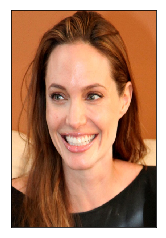

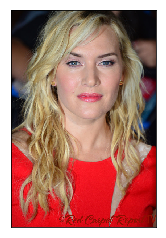

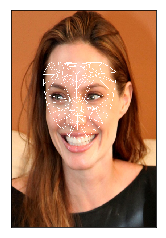

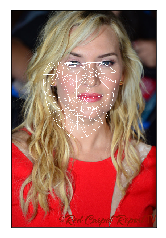

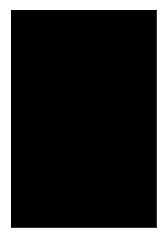

In [7]:
# Using dlib to detect the faces in an image

import cv2
import dlib
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from enum import Enum
from collections import OrderedDict

%matplotlib inline 

class Point(Enum):
    X = 0
    Y = 1

PATH = os.path.join("..","..","..","dependencies")
FILE_NAME = "shape_predictor_68_face_landmarks.dat"

IMAGE_PATH = os.path.join("..","..","images","face_ops")

predictor = dlib.shape_predictor(os.path.join(PATH,FILE_NAME))
detector = dlib.get_frontal_face_detector()


# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions
FACIAL_LANDMARKS_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords


def get_points(image):
    # Note: this function will only recieve faces that have exactly one face
    
    dets = detector(image)
    for k, d in enumerate(dets):

            gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)     

            shape = shape_to_np(predictor(gray, d))

    return shape # where shape is a 68 points list of tuples 


def do_affine_transform(src, src_T, dst_T, size):
    
    #Getting the transformation matrix
    tMat = cv2.getAffineTransform(np.float32(src_T), np.float32(dst_T))
    
    # Next we need to apply the transform on the source
    tImg = cv2.warpAffine(src, tMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR)

    return tImg

def do_morph_face(img1, img2, img3, t1, t2, t3, coeff):
    
    # Creating a bounded rectangle around each triangle
    br1 = cv2.boundingRect(np.float32([t1])) # triangles of image1
    br2 = cv2.boundingRect(np.float32([t2]))# triangles of image2
    br3 = cv2.boundingRect(np.float32([t3])) # triangles of image3
    
    do_affine_transform(img1, img3, (br1[0],br[1])


def do_delaunay_ops(image,points,index):
    
    #getting the image bounds
    image_bound = (0,0, image.shape[1], image.shape[0])
    
    # creating an instance of Subdiv2D , used to generate delaunay as well as voronoi tesselation
    subdiv = cv2.Subdiv2D(image_bound)
    
    subdiv.insert(points)
    
    triplets = subdiv.getTriangleList();
    
    # Holds a triplet of landmark points
    out = []
    
    # we will only take the valid triangles, i.e one's that lie in the face region
    for entry in triplets:
        x1 = entry[0], entry[1]
        x2 = entry[2], entry[3]
        x3 = entry[4], entry[5]
        
        if x1 in index and x2 in index and x3 in index:
            out.append((index[x1],index[x2],index[x3]))
            
    return out

    
# co-eff
coeff = 0.5 # taking mean of the two images
    
img1 = mpimg.imread(os.path.join(IMAGE_PATH,"ang.jpg"))
img2 = mpimg.imread(os.path.join(IMAGE_PATH,"kate.jpg"))

# Making sure they have the same dimensions
img1 = cv2.resize(img1, (400,600))
img2 = cv2.resize(img2, (400,600))

plt.imshow(img1)
plt.xticks([]),plt.yticks([])
plt.show()

plt.imshow(img2)
plt.xticks([]),plt.yticks([])
plt.show()

pts1 = get_points(img1)
pts2 = get_points(img2)

# Since we will be morphing the faces, we will not only do weigted blending
# we will also do weighting landmark calculation between the two images

pts3 = []
for idx in range(len(pts1)):
    x3 = (1-coeff)*pts1[idx][0] + coeff*pts2[idx][0] # weighted landmark x in morphed image
    y3 = (1-coeff)*pts1[idx][1] + coeff*pts2[idx][1]
    pts3.append((x3,y3))
    
# Creating an empty image for the morphed image using np.zeros, with shape == img1
img3 = np.zeros(img1.shape)

# Next since we will be performming delaunay triangulation using the average points (pts3)
#Steps:

# 1. Perform delaunay triangulation using the average points we obtained as in pts3
# 2. We get a triplet of length 68
# 3. And this lead to 3 unique triangles in each image, including img3
# 4. We then perform 2 affine transforms:
#                     img1 -> img3
#                     img2 -> img3
# 5. And then we apply alpha blending with the above blending factor to merge the two triangles to form im3
# 6. repeat 5 for all the triangles that were formed
# 7. we have a morphed face

# Indexing the mean landmark points
# In python, tuples can be keys - wow!
pts_idx = {}
pts_idx_rev = {} # this is the reverse index of pts_idx

# Index the pixel locations against landmark points
for idx,pt in enumerate(pts3):
    pts_idx[pt] = idx+1
    pts_idx_rev[idx+1] = pt
    
triplets = do_delaunay_ops(img3, pts3, pts_idx)
    
# Plotting the triangles-meshes on a face, not we don't care about duplicates
mesh_img1 = img1.copy()
mesh_img2 = img2.copy()

for t in triplets:
    p1 = tuple([int(x)-17 for x in pts_idx_rev[t[0]]])
    p2 = tuple([int(x)-17 for x in pts_idx_rev[t[1]]])
    p3 = tuple([int(x)-17 for x in pts_idx_rev[t[2]]])
    
    
    # Image 1
    cv2.line(mesh_img1, p1, p2, (255, 255, 255) , 1)
    cv2.line(mesh_img1, p2, p3, (255, 255, 255) , 1)
    cv2.line(mesh_img1, p1, p3, (255, 255, 255) , 1)
    
    # Image 2
    cv2.line(mesh_img2, p1, p2, (255, 255, 255) , 1)
    cv2.line(mesh_img2, p2, p3, (255, 255, 255) , 1)
    cv2.line(mesh_img2, p1, p3, (255, 255, 255) , 1)

# Plotting the meshed faces

plt.imshow(mesh_img1)
plt.xticks([]),plt.yticks([])
plt.show()

plt.imshow(mesh_img2)
plt.xticks([]),plt.yticks([])
plt.show()    


# Now we will do the morphing
for t in triplets:
    x, y, z = t
    
    t1 = [pts1[x-1], pts1[y-1], pts1[z-1]]  # The triangles in img1
    t2 = [pts2[x-1], pts2[y-1], pts2[z-1]]  # The triangles in img2
    t3 = [pts3[x-1], pts3[y-1], pts3[z-1]]  # The triangles in img3
 
    do_morph_face(img1, img2, img3, t1, t2, t3, coeff)
    


plt.imshow(img3)
plt.xticks([]),plt.yticks([])
plt.show()        

In [ ]:
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(211)
plt.imshow(oim)
plt.xticks([]), plt.yticks([])


plt.subplot(212)
plt.imshow(im)
plt.xticks([]), plt.yticks([])

plt.show() 

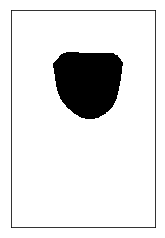

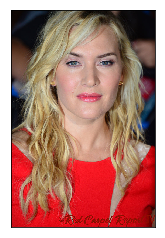

error: /opencv/modules/core/src/arithm.cpp:241: error: (-215) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function binary_op


In [75]:
img1 = mpimg.imread(os.path.join(IMAGE_PATH,"kate.jpg"))
pts1 = get_points(img1)

hull = cv2.convexHull(pts1)

img = img1.copy()

hull = np.array([[x[0][0],x[0][1]] for x in hull],np.int32)
hull = hull.reshape((-1,1,2))
cv2.polylines(img,[hull],True,(255,255,255))

mask = np.ones(img.shape)
cv2.fillConvexPoly(mask, np.int32(hull), (0,0,0))

plt.imshow(mask)
plt.xticks([]),plt.yticks([])
plt.show() 


plt.imshow(img1)
plt.xticks([]),plt.yticks([])
plt.show()

res = cv2.bitwise_and(img,img,mask = mask2)

plt.imshow(res)
plt.xticks([]),plt.yticks([])
plt.show()
